# Crypto Momentum and Mean Reversion Strategies
## Brian Plotnik
### October 2024

This notebook implements momentum and mean reversion strategies on historical daily cryptocurrency price data.

In [2]:
# Import statements
import pandas as pd
import numpy as np
from binance.client import Client as bnb_client
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

# Data Collection

In [3]:
# Pull price timeseries data from Binance
def get_binance_px(symbol,freq,start_ts = '2017-01-01',end_ts='2024-10-01'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data  

In [4]:
# Collect tickers available through Binance API
client = bnb_client(tld='US') # if you're in the US, please use: client=bnb_client(tld='US')'
exchange_info = client.get_exchange_info()

symbols = [i['symbol'] for i in exchange_info['symbols']]
print(symbols)

['BTCUSD4', 'ETHUSD4', 'XRPUSD', 'BCHUSD4', 'LTCUSD4', 'USDTUSD4', 'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'BNBUSD4', 'BNBUSDT', 'ETHBTC', 'XRPBTC', 'BNBBTC', 'LTCBTC', 'BCHBTC', 'ADAUSD4', 'BATUSD4', 'ETCUSD4', 'XLMUSD4', 'ZRXUSD4', 'ADAUSDT', 'BATUSDT', 'ETCUSDT', 'XLMUSDT', 'ZRXUSDT', 'LINKUSD4', 'RVNUSD4', 'DASHUSD4', 'ZECUSD4', 'ALGOUSD4', 'IOTAUSD4', 'BUSDUSD4', 'BTCBUSD', 'DOGEUSDT', 'WAVESUSD4', 'ATOMUSDT', 'ATOMUSD4', 'NEOUSDT', 'NEOUSD4', 'VETUSDT', 'QTUMUSDT', 'QTUMUSD4', 'NANOUSD', 'ICXUSD4', 'ENJUSD4', 'ONTUSD4', 'ONTUSDT', 'ZILUSD4', 'ZILBUSD', 'VETUSD4', 'BNBBUSD', 'XRPBUSD', 'ETHBUSD', 'ALGOBUSD', 'XTZUSD4', 'XTZBUSD', 'HBARUSD4', 'HBARBUSD', 'OMGUSD4', 'OMGBUSD', 'MATICUSD4', 'MATICBUSD', 'XTZBTC', 'ADABTC', 'REPBUSD', 'REPUSD', 'EOSBUSD', 'EOSUSD4', 'DOGEUSD4', 'KNCUSD4', 'KNCUSDT', 'VTHOUSDT', 'VTHOUSD4', 'USDCUSD4', 'COMPUSDT', 'COMPUSD4', 'MANAUSD4', 'HNTUSD4', 'HNTUSDT', 'MKRUSD4', 'MKRUSDT', 'DAIUSD4', 'ONEUSDT', 'ONEUSD4', 'BANDUSDT', 'BANDUSD4', 

In [5]:
# Filter for just the Crypto - USDT pairs
univ = [symbol for symbol in symbols if symbol.endswith('USDT')]
print(univ)
print(str(len(univ)) + " pairs")

['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'BNBUSDT', 'ADAUSDT', 'BATUSDT', 'ETCUSDT', 'XLMUSDT', 'ZRXUSDT', 'DOGEUSDT', 'ATOMUSDT', 'NEOUSDT', 'VETUSDT', 'QTUMUSDT', 'ONTUSDT', 'KNCUSDT', 'VTHOUSDT', 'COMPUSDT', 'HNTUSDT', 'MKRUSDT', 'ONEUSDT', 'BANDUSDT', 'STORJUSDT', 'BUSDUSDT', 'UNIUSDT', 'SOLUSDT', 'EGLDUSDT', 'PAXGUSDT', 'OXTUSDT', 'ZENUSDT', 'FILUSDT', 'AAVEUSDT', 'GRTUSDT', 'SHIBUSDT', 'CRVUSDT', 'AXSUSDT', 'AVAXUSDT', 'CTSIUSDT', 'DOTUSDT', 'YFIUSDT', '1INCHUSDT', 'FTMUSDT', 'USDCUSDT', 'MATICUSDT', 'MANAUSDT', 'ALGOUSDT', 'LINKUSDT', 'EOSUSDT', 'ZECUSDT', 'ENJUSDT', 'NEARUSDT', 'OMGUSDT', 'SUSHIUSDT', 'LRCUSDT', 'LPTUSDT', 'POLYUSDT', 'NMRUSDT', 'SLPUSDT', 'ANTUSDT', 'CHZUSDT', 'OGNUSDT', 'GALAUSDT', 'TLMUSDT', 'SNXUSDT', 'AUDIOUSDT', 'ENSUSDT', 'REQUSDT', 'APEUSDT', 'FLUXUSDT', 'TRXUSDT', 'COTIUSDT', 'VOXELUSDT', 'RLCUSDT', 'USTUSDT', 'BICOUSDT', 'API3USDT', 'BNTUSDT', 'IMXUSDT', 'SPELLUSDT', 'JASMYUSDT', 'FLOWUSDT', 'GTCUSDT', 'THETAUSDT', 'TFUELUSDT', 'OCEANUS

In [6]:
# Collect daily cryptocurrency close prices
freq = '1d'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()
ret

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,BNBUSDT,ADAUSDT,BATUSDT,ETCUSDT,XLMUSDT,...,ORBSUSDT,CUDOSUSDT,ADXUSDT,FORTUSDT,SUIUSDT,ONGUSDT,GUSDT,RENDERUSDT,BONKUSDT,MAGICUSDT
2019-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-24,-0.142038,-0.202625,-0.148182,-0.279268,-0.216227,-0.201381,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-25,-0.009905,0.017416,0.057557,0.022830,-0.002948,0.011949,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-26,-0.043967,-0.019471,-0.012275,-0.047116,-0.039652,-0.052480,-0.028462,-0.061849,-0.068501,0.023398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-27,0.014176,0.041994,-0.008600,0.022404,0.006519,0.025075,0.032990,0.079634,0.000612,-0.022522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,0.011284,0.023668,-0.000510,0.027444,0.039264,0.017770,0.001497,-0.002568,0.031683,0.006122,...,0.016841,-0.004863,0.054264,0.031426,0.005435,0.078882,0.044895,0.062371,NaN,NaN
2024-09-28,0.001861,-0.007199,0.043338,-0.018920,-0.017416,-0.011860,-0.002990,-0.009784,-0.016315,0.010142,...,-0.014722,-0.172368,0.000000,-0.001563,0.017058,-0.099885,-0.018168,-0.024350,NaN,NaN
2024-09-29,-0.003603,-0.006664,0.044958,-0.003403,-0.008290,-0.007001,-0.009495,-0.011440,-0.012683,0.020080,...,0.016810,0.163318,-0.000613,0.017214,0.038328,0.053086,-0.005001,0.023886,NaN,NaN
2024-09-30,-0.036221,-0.020766,-0.046298,-0.046670,-0.037187,-0.051704,-0.058527,-0.064703,-0.042490,-0.031496,...,-0.020206,-0.001228,0.000000,-0.020000,0.018144,-0.099605,-0.067856,-0.034844,NaN,NaN


In [7]:
# Separate out bitcoin data to be used as benchmark
btc = px['BTCUSDT']
btc_ret = btc.pct_change()
btc_ret

2019-09-23         NaN
2019-09-24   -0.142038
2019-09-25   -0.009905
2019-09-26   -0.043967
2019-09-27    0.014176
                ...   
2024-09-27    0.011284
2024-09-28    0.001861
2024-09-29   -0.003603
2024-09-30   -0.036221
2024-10-01   -0.036221
Freq: D, Name: BTCUSDT, Length: 1836, dtype: float64

In [8]:
# Remove BTC from backtesting data as it will be the benchmark
ret = ret.drop(columns=['BTCUSDT'])
ret

,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,BNBUSDT,ADAUSDT,BATUSDT,ETCUSDT,XLMUSDT,ZRXUSDT,...,ORBSUSDT,CUDOSUSDT,ADXUSDT,FORTUSDT,SUIUSDT,ONGUSDT,GUSDT,RENDERUSDT,BONKUSDT,MAGICUSDT
2019-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-24,-0.202625,-0.148182,-0.279268,-0.216227,-0.201381,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-25,0.017416,0.057557,0.022830,-0.002948,0.011949,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-26,-0.019471,-0.012275,-0.047116,-0.039652,-0.052480,-0.028462,-0.061849,-0.068501,0.023398,0.038059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-27,0.041994,-0.008600,0.022404,0.006519,0.025075,0.032990,0.079634,0.000612,-0.022522,-0.022915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,0.023668,-0.000510,0.027444,0.039264,0.017770,0.001497,-0.002568,0.031683,0.006122,0.046755,...,0.016841,-0.004863,0.054264,0.031426,0.005435,0.078882,0.044895,0.062371,NaN,NaN
2024-09-28,-0.007199,0.043338,-0.018920,-0.017416,-0.011860,-0.002990,-0.009784,-0.016315,0.010142,-0.038170,...,-0.014722,-0.172368,0.000000,-0.001563,0.017058,-0.099885,-0.018168,-0.024350,NaN,NaN
2024-09-29,-0.006664,0.044958,-0.003403,-0.008290,-0.007001,-0.009495,-0.011440,-0.012683,0.020080,0.019702,...,0.016810,0.163318,-0.000613,0.017214,0.038328,0.053086,-0.005001,0.023886,NaN,NaN
2024-09-30,-0.020766,-0.046298,-0.046670,-0.037187,-0.051704,-0.058527,-0.064703,-0.042490,-0.031496,-0.079492,...,-0.020206,-0.001228,0.000000,-0.020000,0.018144,-0.099605,-0.067856,-0.034844,NaN,NaN


# Performance Evaluation

In [9]:
# Calculates and prints stats for backtest
def performance_stats(strat_ret):
    stats = {}
    stats['SR'] = strat_ret.mean() / strat_ret.std() * np.sqrt(365)
    stats['ret'] = strat_ret.mean()*365
    stats['vol'] = strat_ret.std()*np.sqrt(365)
    stats = pd.Series(stats)
    return stats

def print_performance_stats(stats):
    print("Sharpe Ratio:", round(stats['SR'],4))
    print("Annualized Returns:", round(stats['ret'],4))
    print("Volatility:", round(stats['vol'],4))

In [24]:
def regression_stats(strat_ret, btc_ret):
    X = btc_ret
    X = sm.add_constant(X)
    Y = strat_ret
    X = X.dropna()
    Y = Y.dropna().iloc[1:]
    results = sm.OLS(Y, X).fit()

    stats = {}
    stats['beta_contr'] = results.params['BTCUSDT']*X['BTCUSDT']
    stats['prediction'] = results.params['BTCUSDT']*X['BTCUSDT'] + results.params['const']
    stats['alpha_contr'] = results.resid
    stats['t-stat'] = results.tvalues['const']
    stats['const'] = results.params['const']
    stats = pd.Series(stats)
    return stats

def print_regression_stats(stats):
    daily_alpha = stats['const']
    print(f"Daily Alpha: {daily_alpha:.6f}")
    alpha = (1 + daily_alpha) ** 365 - 1
    information_ratio = daily_alpha/stats['alpha_contr'].std()*np.sqrt(365)
    t_stat = stats['t-stat']

    print("Alpha:", round(alpha,4))
    print("Information Ratio:", round(information_ratio,4))
    print("T-stat:", round(t_stat,4))

# Momentum-Based Strategy
Below is an implementation of a z-score based momentum strategy along with associated parameter optimization

**Findings: This strategy, when backtested over historical daily cryptocurrency prices since 2017, has a sharpe ratio of ~1.2. The best values for short-window and long-window appear to be around 15 days and 150 days**

In [11]:
# Z-Score Momentum signal generation
def z_score_momentum(ret, short_window, long_window, skip_first_day = True):
    # Z-score inputs
    short_term_return = ret.rolling(short_window,min_periods=1).mean()
    rolling_mean = ret.rolling(long_window, min_periods=1).mean()
    rolling_std = ret.rolling(long_window, min_periods=1).std()

    # Z-score calculation - code below calculates z-scores and takes the tanh of the results in order to smoothen outliers
    z_scores = (short_term_return - rolling_mean) / rolling_std
    z_scores = np.tanh(z_scores)
    z_scores = z_scores.div(z_scores.abs().sum(axis=1),axis=0)

    # Gross return calculation, skips the first bar for momentum to avoid exposure to reversal in first time period after signal. 
    # Optionality for skipping first day or not
    if skip_first_day:
        gross_return = (z_scores.shift(2)*ret).sum(1)
    else:
        gross_return = (z_scores.shift(1)*ret).sum(1)
        

    # Calculate turnover and net returns (minus T-costs)
    # Place limit orders (7 bps) with a success rate of ~80% and then the remaining ~20% are filled as market orders (20 bps)
    limit_cost = 7
    market_cost = 20
    limit_fill_rate = 0.8
    to = (z_scores.fillna(0) - z_scores.shift().fillna(0)).abs().sum(axis=1)
    filled_at_limit = np.random.binomial(1, limit_fill_rate, len(to))
    transaction_costs = np.where(filled_at_limit, to * limit_cost * 1e-4, to * market_cost * 1e-4)
    net_return = gross_return.subtract(transaction_costs,fill_value=0)
    return net_return

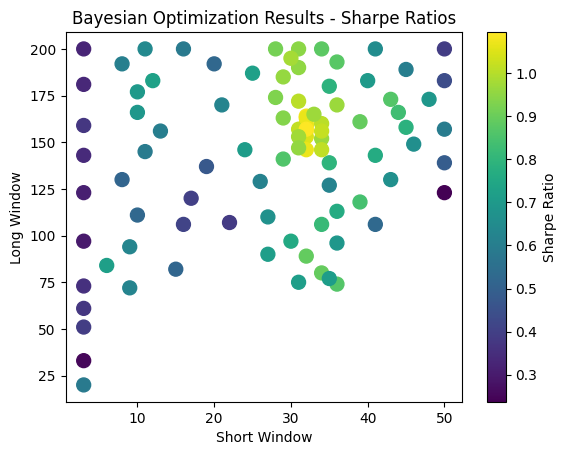

Best short window: 32
Best long window: 157
Best Sharpe Ratio: 1.0944671265321069


In [12]:
# Bayesian Optimization for momentum strategy parameters (rolling windows) - v1 skipping first day
# Best sharpe ratio is ~1.1

space  = [
    Integer(3, 50, name='short_window'),  # Short window: between 3 and 50 days
    Integer(20, 200, name='long_window')  # Long window: between 20 and 200 days
]

results_list = []
def objective(params):
    short_window = params[0]
    long_window = params[1]

    skip_first_day = True
    if long_window >= 2 * short_window:
        returns = z_score_momentum(ret, short_window, long_window, skip_first_day)
        sharpe = performance_stats(returns)['SR']
        results_list.append((short_window, long_window, sharpe))
        return -sharpe

    else:
        return 5

res = gp_minimize(objective,
                  space,
                  n_calls=100,
                  random_state=0,
                  n_initial_points=10,
                  acq_func="EI")

# Convert the results to a DataFrame for easy manipulation
results_df = pd.DataFrame(results_list, columns=['short_window', 'long_window', 'sharpe_ratio'])

# Plot a 2D scatter plot with color representing the Sharpe ratio
plt.scatter(results_df['short_window'], results_df['long_window'], c=results_df['sharpe_ratio'], cmap='viridis', s=100)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Short Window')
plt.ylabel('Long Window')
plt.title('Bayesian Optimization Results - Sharpe Ratios')
plt.show()

# Best parameters
print("Best short window:", res.x[0])
print("Best long window:", res.x[1])

# Best result
print("Best Sharpe Ratio:", -res.fun)

/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [33, 160] before, using random point [20, 134]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [33, 160] before, using random point [8, 152]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [33, 160] before, using random point [48, 183]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [33, 160] before, using random point [49, 109]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/opt

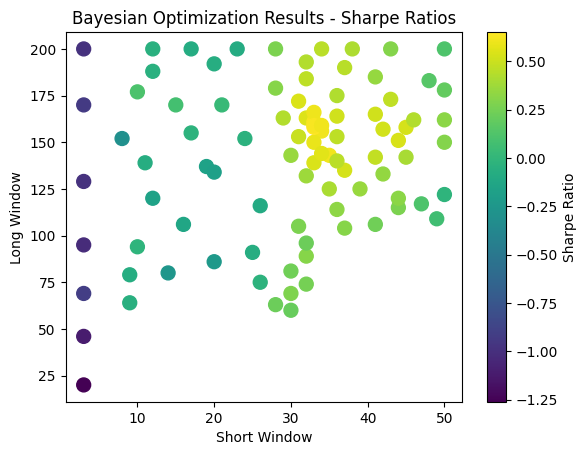

Best short window: 33
Best long window: 158
Best Sharpe Ratio: 0.6508092037534201


In [13]:
# Bayesian Optimization for momentum strategy parameters (rolling windows) - v2 not skipping first day
# Best sharpe ratio is ~0.66

space  = [
    Integer(3, 50, name='short_window'),  # Short window: between 3 and 50 days
    Integer(20, 200, name='long_window')  # Long window: between 20 and 200 days
]

results_list = []
def objective(params):
    short_window = params[0]
    long_window = params[1]

    skip_first_day = False
    if long_window >= 2 * short_window:
        returns = z_score_momentum(ret, short_window, long_window, skip_first_day)
        sharpe = performance_stats(returns)['SR']
        results_list.append((short_window, long_window, sharpe))
        return -sharpe

    else:
        return 5

res = gp_minimize(objective,
                  space,
                  n_calls=100,
                  random_state=0,
                  n_initial_points=10,
                  acq_func="EI")

# Convert the results to a DataFrame for easy manipulation
results_df = pd.DataFrame(results_list, columns=['short_window', 'long_window', 'sharpe_ratio'])

# Plot a 2D scatter plot with color representing the Sharpe ratio
plt.scatter(results_df['short_window'], results_df['long_window'], c=results_df['sharpe_ratio'], cmap='viridis', s=100)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Short Window')
plt.ylabel('Long Window')
plt.title('Bayesian Optimization Results - Sharpe Ratios')
plt.show()

# Best parameters
print("Best short window:", res.x[0])
print("Best long window:", res.x[1])

# Best result
print("Best Sharpe Ratio:", -res.fun)

Z_score Momentum Strategy Results

Sharpe Ratio: 0.9599
Annualized Returns: 0.6748
Volatility: 0.703
Alpha: 1.116
Information Ratio: 1.0748
T-stat: 2.4066


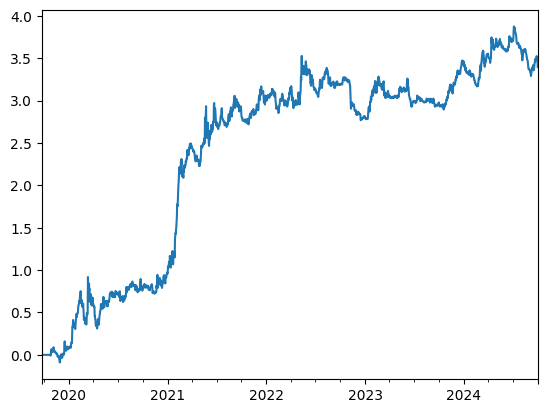

In [21]:
# Simple Z_score momentum results with optimized parameters and skipping first day
portfolio_returns = z_score_momentum(ret,30,150, True)
portfolio_returns.cumsum().plot()

print("Z_score Momentum Strategy Results\n")
stats = performance_stats(portfolio_returns)
regression = regression_stats(portfolio_returns, btc_ret)
print_performance_stats(stats)
print_regression_stats(regression)

# Z-Score Momentum Strategy with Volatility Filter

In an attempt to improve my strategy's sharpe ratio, I implemented a volatility threshold to see if the strategy would give better results when only traded during times with higher volatility.

In [15]:
# Z-Score Momentum with Volatility Filter signal generation
def z_score_momentum_with_volatility_filter(ret, short_window, long_window, vol_threshold):
    # Rolling Volatility
    vol_window = 14
    rolling_volatility = ret.rolling(window=vol_window, min_periods=1).std()

    # Volatility Threshold
    volatility_mean = rolling_volatility.rolling(window=long_window, min_periods=1).mean()  # Long-term average of volatility
    volatility_filter = rolling_volatility < (volatility_mean * vol_threshold) 
    
    # Z-score inputs
    short_term_return = ret.rolling(short_window,min_periods=1).mean()
    rolling_mean = ret.rolling(long_window, min_periods=1).mean()
    rolling_std = ret.rolling(long_window, min_periods=1).std()

    # Z-score calculation - code below calculates z-scores and takes the tanh of the results in order to smoothen outliers
    z_scores = (short_term_return - rolling_mean) / rolling_std
    z_scores = np.tanh(z_scores)
    z_scores = z_scores.div(z_scores.abs().sum(axis=1),axis=0)

    # Apply volatility filter
    z_scores = z_scores.where(volatility_filter, 0)

    # Gross return calculation
    gross_return = (z_scores.shift(2)*ret).sum(1)

    # Calculate turnover and net returns (minus T-costs)
    # Place limit orders (7 bps) with a success rate of 80% and then the remaining 20% are filled as market orders (20 bps)
    limit_cost = 7
    market_cost = 20
    limit_fill_rate = 0.8
    to = (z_scores.fillna(0) - z_scores.shift().fillna(0)).abs().sum(axis=1)
    filled_at_limit = np.random.binomial(1, limit_fill_rate, len(to))
    transaction_costs = np.where(filled_at_limit, to * limit_cost * 1e-4, to * market_cost * 1e-4)
    net_return = gross_return.subtract(transaction_costs,fill_value=0)
    return net_return

/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 500] before, using random point [32, 33]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 500] before, using random point [27, 30]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [32, 425] before, using random point [37, 440]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [32, 430] before, using random point [13, 72]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optim

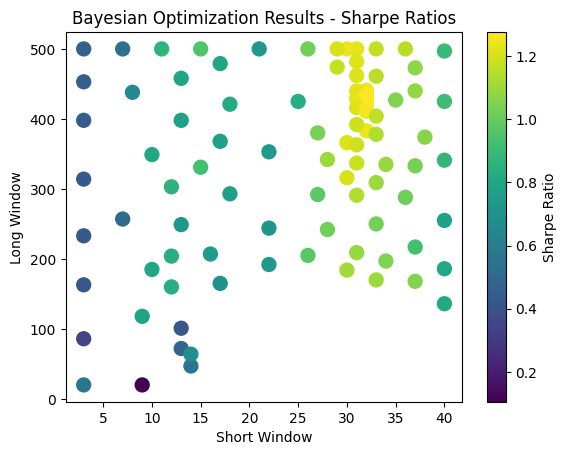

Best short window: 32
Best long window: 432
Best Sharpe Ratio: 1.275056048571435


In [16]:
# Bayesian Optimization for momentum strategy parameters (rolling windows), using volatility threshold of 1 as starting point

space  = [
    Integer(3, 40, name='short_window'),  # Short window: between 3 and 40 days
    Integer(20, 500, name='long_window'),  # Long window: between 20 and 500 days
]

results_list = []
def objective(params):
    short_window = params[0]
    long_window = params[1]
    
    if long_window >= 2 * short_window:
        volatility_filter = 2
        returns = z_score_momentum_with_volatility_filter(ret, short_window, long_window, volatility_filter)
        sharpe = performance_stats(returns)['SR']
        results_list.append((short_window, long_window, sharpe))
        return -sharpe

    else:
        return 5

res = gp_minimize(objective,
                  space,
                  n_calls=100,
                  random_state=0,
                  n_initial_points=10,
                  acq_func="EI")

# Convert the results to a DataFrame for easy manipulation
results_df = pd.DataFrame(results_list, columns=['short_window', 'long_window','sharpe_ratio'])

# Plot a 2D scatter plot with color representing the Sharpe ratio
plt.scatter(results_df['short_window'], results_df['long_window'], c=results_df['sharpe_ratio'], cmap='viridis', s=100)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Short Window')
plt.ylabel('Long Window')
plt.title('Bayesian Optimization Results - Sharpe Ratios')
plt.show()

# Best parameters
print("Best short window:", res.x[0])
print("Best long window:", res.x[1])

# Best result
print("Best Sharpe Ratio:", -res.fun)

Z_score Momentum With Volatility Filter Strategy Results

Sharpe Ratio: 1.2415
Annualized Returns: 0.8011
Volatility: 0.6453
Daily Alpha: 0.002410
Alpha: 1.4074
Information Ratio: 1.3756
T-stat: 3.0802


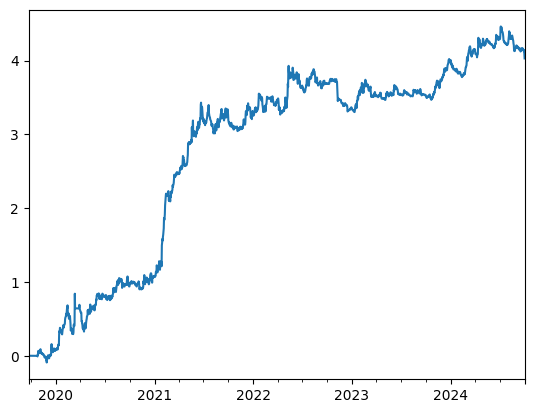

In [25]:
# Simple Z_score momentum results with optimized parameters and skipping first day
momentum_with_volatility = z_score_momentum_with_volatility_filter(ret,30,450, 2)
momentum_with_volatility.cumsum().plot()

print("Z_score Momentum With Volatility Filter Strategy Results\n")
stats = performance_stats(momentum_with_volatility)
regression = regression_stats(momentum_with_volatility, btc_ret)
print_performance_stats(stats)
print_regression_stats(regression)

In [19]:
# Combine strategy and benchmark returns into a single DataFrame
combined = pd.concat([momentum_with_volatility, btc_ret], axis=1)
combined.columns = ['strat_ret', 'btc_ret']

# Drop rows with missing values
combined = combined.dropna()

# Prepare data for regression
X = sm.add_constant(combined['btc_ret'])  # Benchmark returns with constant
Y = combined['strat_ret']                # Strategy returns

# Ensure indices match and are sorted
assert (X.index == Y.index).all(), "Indices of X and Y do not match!"
assert X.index.is_monotonic_increasing, "Indices are not sorted!"

## Preliminary Findings
The inverse volatility filter I applied seems to improve the strategy's sharpe ratio by trading the momentum strategy during periods of lower volatility. Below I test different volatility filter values to see which range works best for the inverse volatility filter

**Findings: It seems applying a volatility filter results in slightly higher sharpe ratios (of ~1.2) than the strategy without volatility filters**

In [17]:
# Testing different volatility thresholds
vols = {}
for i in range(1,30,1):
    vols[i] = performance_stats(z_score_momentum_with_volatility_filter(ret, 30, 450, i*0.1))['SR']
vols

{1: -0.7341520152547673,
 2: -0.4420176636817225,
 3: 0.17408385511421123,
 4: 0.39537494862695055,
 5: 0.3906089106467004,
 6: 0.6030499541449025,
 7: 0.5265170090581387,
 8: 0.7164362151081451,
 9: 0.8450096902009326,
 10: 0.8037824122665829,
 11: 1.0461339245424572,
 12: 1.1161022019621543,
 13: 1.1257596821088816,
 14: 1.170666441249135,
 15: 1.1556278420907677,
 16: 1.1669551401082787,
 17: 1.2311436074894095,
 18: 1.26460131822454,
 19: 1.2552453167899933,
 20: 1.2438353470685997,
 21: 1.1962122239333826,
 22: 1.1827108156894672,
 23: 1.2113931267122193,
 24: 1.2106693980310537,
 25: 1.207973168881344,
 26: 1.215806689612254,
 27: 1.1902179683894898,
 28: 1.1669346415084307,
 29: 1.1591039131302265}

## Additional Findings

It seems that this momentum-based z-score strategy performed well before 2021 but has not shown great returns since 2021. Below I will implement a reversion strategy to see what kind of results it gives. Perhaps if it does well during the period after 2021, I can combine the 2 strategies to allocate money towards the strategy that is most effective during the regime at that time

Z_score Momentum With Volatility Filter Strategy Results

Sharpe Ratio: 1.2434
Annualized Returns: 0.8026
Volatility: 0.6455
Alpha: 1.4114
Information Ratio: 1.3779
T-stat: 3.0853


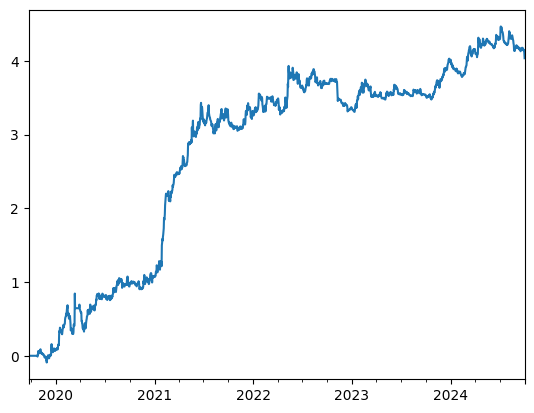

In [18]:
# Example of z-score momentum with volatility_filter = 2
momentum_with_volatility = z_score_momentum_with_volatility_filter(ret, 30, 450, 2)
momentum_with_volatility.cumsum().plot()
print("Z_score Momentum With Volatility Filter Strategy Results\n")
stats = performance_stats(momentum_with_volatility)
regression = regression_stats(momentum_with_volatility, btc_ret)
print_performance_stats(stats)
print_regression_stats(regression)

# Reversal Strategies

Below is an implementation of a several mean reversion strategy that trade on daily crypto data. In these strategies, we use the residuals in order to remove the BTC component of the returns. I tested a z-score mean reversion strategy that uses normalized weights with a z-score threshold (sell if over the threshold and buy if under).

## Reversal Backtest without T-costs

In [19]:
# Calculate Residuals for mean reversion strategies - stripping out BTC component of returns, using mininum periods of 30 days to avoid
# noise at the beginning
def calc_resid(ret, btc_ret):
    corr = ret.rolling(180, min_periods=30).corr(btc_ret)
    vol = ret.rolling(180, min_periods=30).std()
    beta = (corr*vol).divide(vol,axis=0)
    resid = ret - beta.multiply(btc_ret,0)
    return resid

resid = calc_resid(ret, btc_ret)
resid

,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,BNBUSDT,ADAUSDT,BATUSDT,ETCUSDT,XLMUSDT,ZRXUSDT,...,XTZUSDT,ZILUSDT,ORBSUSDT,CUDOSUSDT,ADXUSDT,FORTUSDT,SUIUSDT,ONGUSDT,GUSDT,RENDERUSDT
2019-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,0.014295,-0.006401,0.018907,0.032027,0.009232,-0.006988,-0.010506,0.023551,-0.000462,0.038851,...,0.017006,0.043025,0.012325,-0.009284,0.051553,0.029449,-0.001839,0.075339,0.035873,0.054847
2024-09-28,-0.008742,0.042373,-0.020326,-0.018605,-0.013266,-0.004386,-0.011091,-0.017652,0.009061,-0.039468,...,-0.021414,-0.039687,-0.015459,-0.173067,-0.000436,-0.001883,0.015854,-0.100460,-0.019651,-0.025585
2024-09-29,-0.003688,0.046793,-0.000651,-0.005794,-0.004292,-0.006811,-0.008940,-0.010122,0.022130,0.022185,...,0.013672,0.010624,0.018195,0.164577,0.000214,0.017788,0.040630,0.054202,-0.002130,0.026264
2024-09-30,0.009118,-0.027610,-0.018551,-0.011375,-0.024361,-0.031376,-0.039429,-0.016657,-0.010707,-0.054327,...,-0.027843,-0.070374,-0.006243,0.011349,0.008225,-0.014155,0.041161,-0.088211,-0.038440,-0.010687


In [20]:
# Normalized Z-score mean reversion (without T-costs)
def z_score_mean_reversion(ret, short_window, long_window, z_threshold=1):
    # Z-score inputs
    short_term_return = ret.rolling(short_window, min_periods=1).mean()
    rolling_mean = ret.rolling(long_window, min_periods=1).mean()
    rolling_std = ret.rolling(long_window, min_periods=1).std()

    # Z-score calculation: no tanh applied since mean-reversion is looking for extremes
    z_scores = (ret - rolling_mean) / rolling_std

    # Generate signals: Buy when Z-score < -z_threshold (oversold), Sell when Z-score > z_threshold (overbought)
    buy_signals = z_scores < -z_threshold
    sell_signals = z_scores > z_threshold

    # Combine buy and sell signals into a single DataFrame: 1 for Buy, -1 for Sell, 0 otherwise
    signals = pd.DataFrame(0, index=ret.index, columns=ret.columns)
    signals[buy_signals] = 1  # Buy signal
    signals[sell_signals] = -1  # Sell signal

    # Normalize signals to ensure full investment, but adjust total exposure based on the number of active assets
    signal_sum = signals.abs().sum(axis=1)
    num_active_signals = (signals != 0).sum(axis=1)
    normalized_signals = signals.div(signal_sum, axis=0).fillna(0)

    # Dynamically scale exposure based on number of active assets
    scaled_signals = normalized_signals.multiply(num_active_signals / signal_sum.max(), axis=0)

    # Calculate gross returns: Shift signals by 1 to avoid look-ahead bias (next-day return)
    gross_return = (scaled_signals.shift(1) * ret).sum(axis=1)

    """
    to = signals.diff().abs().sum(axis=1)

    # Place limit orders (80% success) and market orders (20%)
    limit_cost = 7
    market_cost = 20
    limit_fill_rate = 0.8
    filled_at_limit = np.random.binomial(1, limit_fill_rate, len(to))  # Generate limit order fills
    transaction_costs = np.where(filled_at_limit, to * limit_cost * 1e-4, to * market_cost * 1e-4)

    # Calculate net returns after transaction costs
    net_return = gross_return.subtract(transaction_costs, fill_value=0)
    """
    # Returns gross returns to show strategy effectiveness before incorporating T-costs
    return gross_return

/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 100] before, using random point [78, 260]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [6, 100] before, using random point [54, 248]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [6, 103] before, using random point [31, 31]
  warnings.warn(


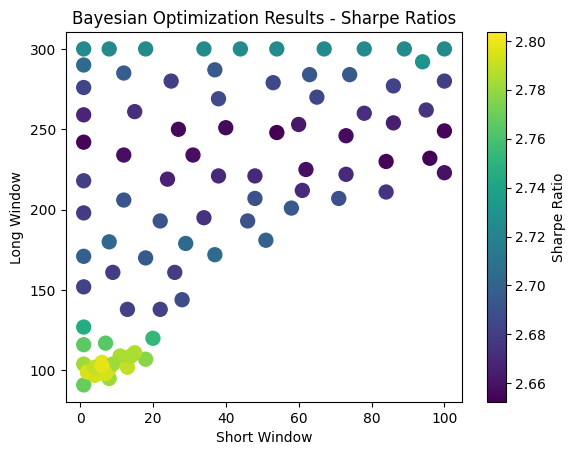

Best short window: 7
Best long window: 100
Best Sharpe Ratio: 2.8035577032576042


In [21]:
# Bayesian Optimization for Reversal strategy parameters (rolling windows), using z-score threshold = 1 as starting point

space  = [
    Integer(1, 100, name='short_window'),  # Short window: between 1 and 100 days
    Integer(1, 300, name='long_window'),  # Long window: between 1 and 300 days
]

results_list = []
def objective(params):
    short_window = params[0]
    long_window = params[1]
    
    if long_window >= 2 * short_window:
        returns = z_score_mean_reversion(resid, short_window, long_window, 1)
        sharpe = performance_stats(returns)['SR']
        results_list.append((short_window, long_window, sharpe))
        return -sharpe

    else:
        return 5

res = gp_minimize(objective,
                  space,
                  n_calls=100,
                  random_state=0,
                  n_initial_points=10,
                  acq_func="EI")

# Convert the results to a DataFrame for easy manipulation
results_df = pd.DataFrame(results_list, columns=['short_window', 'long_window','sharpe_ratio'])

# Plot a 2D scatter plot with color representing the Sharpe ratio
plt.scatter(results_df['short_window'], results_df['long_window'], c=results_df['sharpe_ratio'], cmap='viridis', s=100)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Short Window')
plt.ylabel('Long Window')
plt.title('Bayesian Optimization Results - Sharpe Ratios')
plt.show()

# Best parameters
print("Best short window:", res.x[0])
print("Best long window:", res.x[1])

# Best result
print("Best Sharpe Ratio:", -res.fun)

Z_score Reversion Strategy Results (no T-Costs)

Sharpe Ratio: 2.8036
Annualized Returns: 0.4058
Volatility: 0.1447
Alpha: 0.4782
Information Ratio: 2.7197
T-stat: 6.09


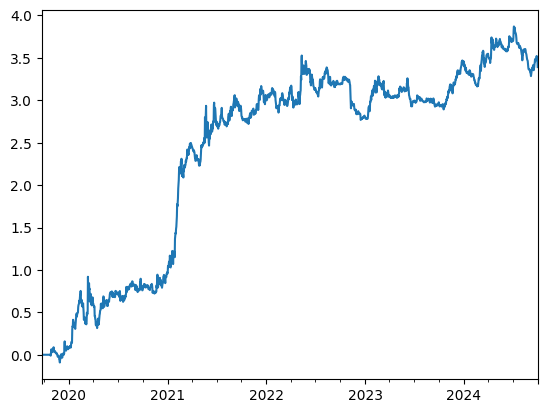

In [22]:
z_score_mean_reversion_results = z_score_mean_reversion(resid, 7, 100, 1)
portfolio_returns.cumsum().plot()
print("Z_score Reversion Strategy Results (no T-Costs)\n")
stats = performance_stats(z_score_mean_reversion_results)
regression = regression_stats(z_score_mean_reversion_results, btc_ret)
print_performance_stats(stats)
print_regression_stats(regression)

## Reversal Strategy with T-costs

In [23]:
def z_score_mean_reversion_net(ret, short_window, long_window, z_threshold=1):
    # Z-score inputs
    short_term_return = ret.rolling(short_window, min_periods=1).mean()
    rolling_mean = ret.rolling(long_window, min_periods=1).mean()
    rolling_std = ret.rolling(long_window, min_periods=1).std()

    # Z-score calculation: no tanh applied since mean-reversion is looking for extremes
    z_scores = (ret - rolling_mean) / rolling_std

    # Generate signals: Buy when Z-score < -z_threshold (oversold), Sell when Z-score > z_threshold (overbought)
    buy_signals = z_scores < -z_threshold
    sell_signals = z_scores > z_threshold

    # Combine buy and sell signals into a single DataFrame: 1 for Buy, -1 for Sell, 0 otherwise
    signals = pd.DataFrame(0, index=ret.index, columns=ret.columns)
    signals[buy_signals] = 1  # Buy signal
    signals[sell_signals] = -1  # Sell signal

    # Normalize signals to ensure full investment, but adjust total exposure based on the number of active assets
    signal_sum = signals.abs().sum(axis=1)
    num_active_signals = (signals != 0).sum(axis=1)
    normalized_signals = signals.div(signal_sum, axis=0).fillna(0)

    # Dynamically scale exposure based on number of active assets
    scaled_signals = normalized_signals.multiply(num_active_signals / signal_sum.max(), axis=0)

    # Calculate gross returns: Shift signals by 1 to avoid look-ahead bias (next-day return)
    gross_return = (scaled_signals.shift(1) * ret).sum(axis=1)

    to = scaled_signals.diff().abs().sum(axis=1)
    
    # Place limit orders (80% success) and market orders (20%)
    limit_cost = 7
    market_cost = 20
    limit_fill_rate = 0.8
    filled_at_limit = np.random.binomial(1, limit_fill_rate, len(to))  # Generate limit order fills
    transaction_costs = np.where(filled_at_limit, to * limit_cost * 1e-4, to * market_cost * 1e-4)

    # Calculate net returns after transaction costs
    net_return = gross_return.subtract(transaction_costs, fill_value=0)
    return net_return

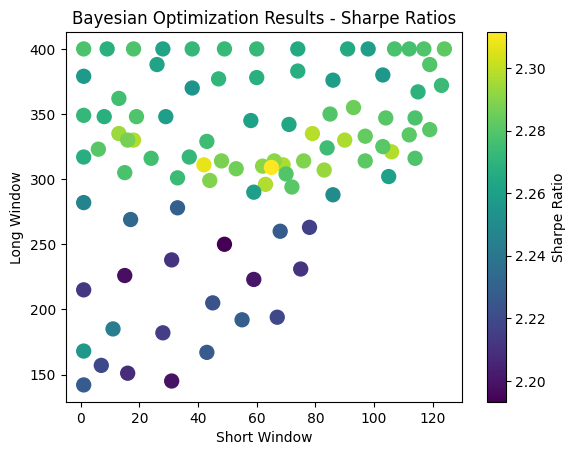

Best short window: 65
Best long window: 309
Best Sharpe Ratio: 2.3114332041517818


In [24]:
# Bayesian Optimization for Reversal strategy parameters (rolling windows), using z-score threshold = 1.5 as starting point

space  = [
    Integer(1, 200, name='short_window'),  # Short window: between 1 and 200 days
    Integer(1, 400, name='long_window'),  # Long window: between 1 and 400 days
]

results_list = []
def objective(params):
    short_window = params[0]
    long_window = params[1]
    
    if long_window >= 2 * short_window:
        returns = z_score_mean_reversion_net(resid, short_window, long_window, 1)
        sharpe = performance_stats(returns)['SR']
        results_list.append((short_window, long_window, sharpe))
        return -sharpe

    else:
        return 5

res = gp_minimize(objective,
                  space,
                  n_calls=100,
                  random_state=0,
                  n_initial_points=10,
                  acq_func="EI")

# Convert the results to a DataFrame for easy manipulation
results_df = pd.DataFrame(results_list, columns=['short_window', 'long_window','sharpe_ratio'])

# Plot a 2D scatter plot with color representing the Sharpe ratio
plt.scatter(results_df['short_window'], results_df['long_window'], c=results_df['sharpe_ratio'], cmap='viridis', s=100)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Short Window')
plt.ylabel('Long Window')
plt.title('Bayesian Optimization Results - Sharpe Ratios')
plt.show()

# Best parameters
print("Best short window:", res.x[0])
print("Best long window:", res.x[1])

# Best result
print("Best Sharpe Ratio:", -res.fun)

Sharpe Ratio: 2.2693
Annualized Returns: 0.319
Volatility: 0.1406
Alpha: 0.3551
Information Ratio: 2.1783
T-stat: 4.8776


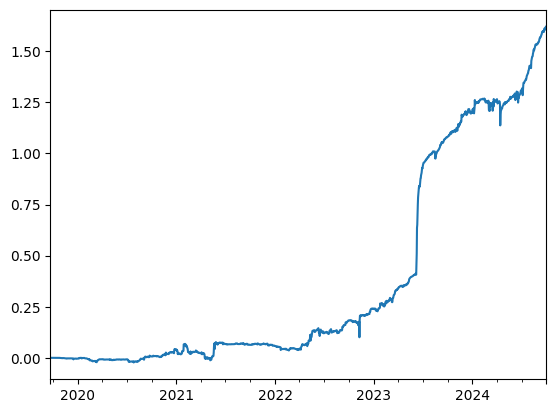

In [25]:
mean_reversion_net = z_score_mean_reversion_net(resid, 100, 300, 1)
mean_reversion_net.cumsum().plot()
stats = performance_stats(mean_reversion_net)
regression = regression_stats(mean_reversion_net, btc_ret)
print_performance_stats(stats)
print_regression_stats(regression)

# Combining Strategies

In [26]:
combined_df = pd.concat([momentum_with_volatility, mean_reversion_net], axis=1)
combined_df.columns = ['Return_momentum', 'Return_mean_reversion']

# Step 2: Calculate the combined 50/50 returns
combined_df['Combined_Return'] = 0.5 * combined_df['Return_momentum'] + 0.5 * combined_df['Return_mean_reversion']
combined_df

,Return_momentum,Return_mean_reversion,Combined_Return
2019-09-23,0.000000,0.000000,0.000000
2019-09-24,0.000000,0.000000,0.000000
2019-09-25,0.000000,0.000000,0.000000
2019-09-26,0.000000,0.000000,0.000000
2019-09-27,0.000000,0.000000,0.000000
...,...,...,...
2024-09-27,0.004274,-0.000428,0.001923
2024-09-28,-0.019052,0.005163,-0.006944
2024-09-29,0.010533,0.005846,0.008189
2024-09-30,-0.043668,-0.001917,-0.022792


Sharpe Ratio: 1.7108
Annualized Returns: 0.5608
Volatility: 0.3278
Alpha: 0.8079
Information Ratio: 1.8182
T-stat: 4.0712


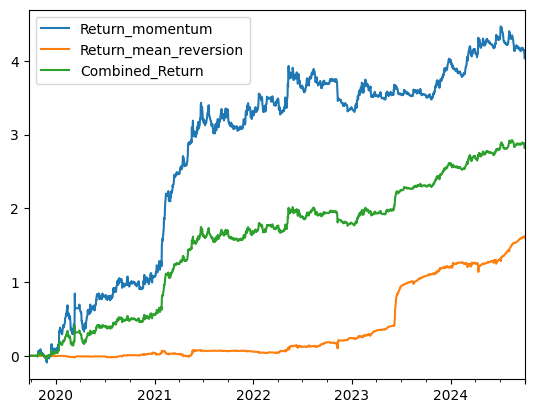

In [27]:
combined_df.cumsum().plot()
stats = performance_stats(combined_df['Combined_Return'])
regression = regression_stats(combined_df['Combined_Return'], btc_ret)
print_performance_stats(stats)
print_regression_stats(regression)

# Findings and Next Steps

I was able to successfully backtest momentum and mean reversion strategy on daily crypto price data. Both of these strategies displayed alpha over the market (BTC returns) and quite good Sharpe Ratios. I was able to create a combined portfolio that invest half of its capital in each strategy and this combined strategy has a sharpe ratio of ~1.7 generating consistent returns.

In order to improve these strategies I would like to explore dynamic portfolio allocation between the momentum and mean reversion strategies to more effectively allocate capital to the strategy that is expected to perform best during a given market regime. I will also continue to explore different signals like RSI signals and bollinger bands to see if these signals provide better results in the crypto market.

Additionally, my current implementation uses the entire dataset for parameter testing. I would like to explore walk-forward analysis and corss-validation to see if the strategy holds up out of sample.

# Work in Progress Signals

### Simple Z-score reversal (using raw z-score for weights)

In [34]:
def simple_reversal_zscore(resid, short_window, long_window):
    short_term_return = resid.rolling(short_window, min_periods=1).mean()
    rolling_mean = resid.rolling(long_window, min_periods=1).mean()
    rolling_std = resid.rolling(long_window, min_periods=1).std()

    # Z-score calculation: no tanh applied since mean-reversion is looking for extremes
    z_scores = (short_term_return - rolling_mean) / rolling_std
    gross_return = (-z_scores.shift(1) * resid).sum(axis=1)
    return gross_return

/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 28] before, using random point [37, 190]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 28] before, using random point [19, 174]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 28] before, using random point [66, 137]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 28] before, using random point [74, 201]
  warnings.warn(
/Users/BrianPlotnik/opt/anaconda3/envs/py38-env/lib/python3.8/site-packages/skopt/optimizer/

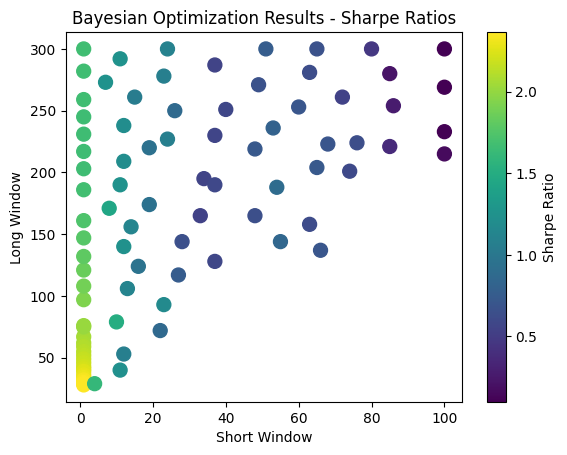

Best short window: 1
Best long window: 29
Best Sharpe Ratio: 2.3638897760733024


In [35]:
# Bayesian Optimization for Reversal strategy parameters (rolling windows), using z-score threshold = 1 as starting point

space  = [
    Integer(1, 100, name='short_window'),  # Short window: between 1 and 100 days
    Integer(1, 300, name='long_window'),  # Long window: between 1 and 300 days
]

results_list = []
def objective(params):
    short_window = params[0]
    long_window = params[1]
    
    if long_window >= 2 * short_window:
        returns = simple_reversal_zscore(resid, short_window, long_window)
        sharpe = performance_stats(returns)['SR']
        results_list.append((short_window, long_window, sharpe))
        return -sharpe

    else:
        return 5

res = gp_minimize(objective,
                  space,
                  n_calls=100,
                  random_state=0,
                  n_initial_points=10,
                  acq_func="EI")

# Convert the results to a DataFrame for easy manipulation
results_df = pd.DataFrame(results_list, columns=['short_window', 'long_window','sharpe_ratio'])

# Plot a 2D scatter plot with color representing the Sharpe ratio
plt.scatter(results_df['short_window'], results_df['long_window'], c=results_df['sharpe_ratio'], cmap='viridis', s=100)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Short Window')
plt.ylabel('Long Window')
plt.title('Bayesian Optimization Results - Sharpe Ratios')
plt.show()

# Best parameters
print("Best short window:", res.x[0])
print("Best long window:", res.x[1])

# Best result
print("Best Sharpe Ratio:", -res.fun)

Simple Z_score Reversion Strategy Results

Sharpe Ratio: 2.3639
Annualized Returns: 158.2541
Volatility: 66.9465
Alpha: 0.4207
Information Ratio: 2.3005
T-stat: 5.1513


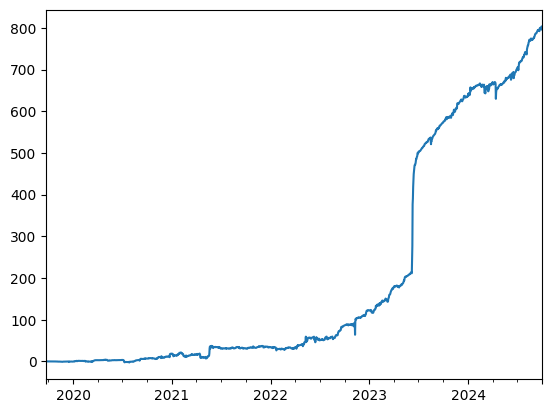

In [38]:
portfolio_returns = simple_reversal_zscore(resid, 1, 29)
portfolio_returns.cumsum().plot()
print("Simple Z_score Reversion Strategy Results\n")
stats = performance_stats(portfolio_returns)
regression = regression_stats(portfolio_returns, btc_ret)
print_performance_stats(stats)
print_regression_stats(regression)

In [ ]:
# RSI Signal Generator
def rsi_signal(ret, hor=14):
    delta = ret.diff()
    gain = (delta.where(delta > 0, 0)).rolling(hor, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(hor, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1+rs))

    rsi_long = (30 - rsi).clip(lower=0) / 30
    rsi_short = (rsi - 70).clip(lower=0) / 30
    weights = rsi_long - rsi_short
    gross_return = (weights.shift()*ret).sum(1)

    #Calculate Net Returns
    #to = (weights.fillna(0) - weights.shift().fillna(0)).abs().sum()
    to = 0
    net_return = gross_return.subtract(to*7*1e-4,fill_value=0)
    return net_return

In [ ]:
# Z-score Signal Generator
def z_score_reversal(ret, short_window, long_window):
    # Z-score inputs
    short_term_return = ret.rolling(short_window,min_periods=1).mean()
    rolling_mean = ret.rolling(long_window, min_periods=1).mean()
    rolling_std = ret.rolling(long_window, min_periods=1).std()

    # Z-score calculation - code below calculates z-scores and takes the tanh of the results in order to smoothen outliers
    z_scores = (short_term_return - rolling_mean) / rolling_std
    z_scores = -np.tanh(z_scores)
    z_scores = z_scores.div(z_scores.abs().sum(axis=1),axis=0)

    # Gross return calculation
    gross_return = (z_scores.shift()*ret).sum(1)

    # Calculate turnover and net returns (minus T-costs)
    # Place limit orders (7 bps) with a success rate of 80% and then the remaining 20% are filled as market orders (20 bps)
    limit_cost = 7
    market_cost = 20
    limit_fill_rate = 0.8
    to = (z_scores.fillna(0) - z_scores.shift().fillna(0)).abs().sum(axis=1)
    filled_at_limit = np.random.binomial(1, limit_fill_rate, len(to))
    transaction_costs = np.where(filled_at_limit, to * limit_cost * 1e-4, to * market_cost * 1e-4)
    net_return = gross_return.subtract(transaction_costs,fill_value=0)
    return net_return

In [ ]:
# Rank Demeaned Normalized Reversal Signal Generator
def rank_demeaned_normalized(ret, hor):
    avg_ret = (-1*ret.rolling(hor,min_periods=1).mean()).rank(1)
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    #to = (avg_ret.fillna(0) - avg_ret.shift().fillna(0)).abs().sum()
    to = 0
    gross_ret = (avg_ret.shift()*ret).sum(1)
    net_ret = gross_ret.subtract(to*20*1e-4,fill_value=0)
    return net_ret

## Bollinger Bands

In [41]:
# Collect Data
client = bnb_client(tld='US') # if you're in the US, please use: client=bnb_client(tld='US')'
univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()
ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2019-09-23 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-23 12:00:00,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN
2019-09-23 16:00:00,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN
2019-09-23 20:00:00,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN
2019-09-24 00:00:00,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...
2024-08-31 08:00:00,-0.001016,0.001610,0.000574,-0.001495,0.003705,-0.000932,-0.003298
2024-08-31 12:00:00,-0.001008,-0.002875,-0.000287,-0.001123,-0.005098,-0.005361,-0.002127
2024-08-31 16:00:00,-0.003572,-0.008049,-0.004878,-0.003373,0.002297,-0.007734,-0.011843
2024-08-31 20:00:00,0.002695,0.006041,-0.006344,-0.000752,-0.002115,0.004015,0.005034


In [42]:
# Bollinger Bands
def bollinger_bands(px, window, num_std):
    df = {}
    rolling_mean = px.rolling(window=window, min_periods=1).mean()
    rolling_std = px.rolling(window=window, min_periods=1).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)

    return rolling_mean, upper_band, lower_band

In [43]:
def calculate_filters(df, window_ma, window_adx, window_atr):
    # Moving Average (Trend Filter) for each coin
    ma = df.rolling(window=window_ma, min_periods=1).mean()

    # ATR using absolute price changes for each coin
    price_diff = df.diff().abs()
    atr = price_diff.rolling(window=window_atr, min_periods=1).mean()

    # Calculate the "directional movement" for ADX using single price changes for each coin
    plus_dm = df.diff().clip(lower=0)  # Upward movement
    minus_dm = (-df.diff()).clip(lower=0)  # Downward movement

    plus_di = 100 * (plus_dm.rolling(window=window_adx).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=window_adx).mean() / atr)

    dx = (np.abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=window_adx).mean()

    return ma, atr, adx

In [44]:
def generate_signals(df, upper_band, lower_band, middle_band, ma, atr, adx, atr_threshold=1, adx_threshold=20):
    signals = pd.DataFrame(index=df.index, columns=df.columns)

    # Trend Filter: Only buy when price is above the moving average, and sell when below for each coin
    buy_condition = (df > upper_band) & (df > ma)
    sell_condition = (df < lower_band) & (df < ma)

    # ADX Filter: Only trade when the ADX is above a threshold for each coin
    strong_trend_condition = adx > adx_threshold

    # ATR Filter: Only trade when ATR is above a minimum threshold for each coin
    volatile_market_condition = atr > atr_threshold

    # Combine conditions: Only trade when all filters are satisfied for each coin
    signals[buy_condition & strong_trend_condition & volatile_market_condition] = 1  # Buy Signal
    signals[sell_condition & strong_trend_condition & volatile_market_condition] = -1  # Sell Signal

    # Forward fill the signals to maintain positions until the next signal for each coin
    signals = signals.fillna(0).replace(0, method='ffill')

    return signals

In [45]:
def normalize_weights(signals):
    weights = signals.div(signals.abs().sum(axis=1), axis=0)
    return weights.fillna(0)

In [46]:
def backtest(ret, weights):
    portfolio_returns = (weights.shift(1) * ret).sum(axis=1)
    return portfolio_returns

1.133076418480648

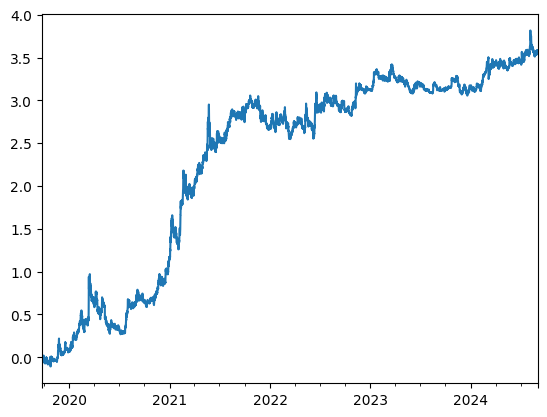

In [47]:
rolling_mean, upper_band, lower_band = bollinger_bands(px,15,1)
ma, atr, adx = calculate_filters(px, window_ma=50, window_adx=14, window_atr=14)
signals = generate_signals(px, upper_band, lower_band, rolling_mean, ma, atr, adx, atr_threshold=1, adx_threshold=5)
weights = normalize_weights(signals)
portfolio_returns = backtest(ret, weights)
portfolio_returns.cumsum().plot()
sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(365*6)
sharpe

In [66]:
# DO NOT RUN - Optimizing Z-Score Momentum Parameters (Brute force) - this method took too long given it is O(n^2) so I opted for 
# Bayesian Optimization instead
def precompute_rolling_means(data, window_range):
    rolling_means = {}
    for window in window_range:
        rolling_means[window] = data.rolling(window=window).mean()
    return rolling_means

def precompute_rolling_std(data, window_range):
    rolling_stds = {}
    for window in window_range:
        rolling_stds[window] = data.rolling(window=window).std()
    return rolling_stds

def grid_search(signals, short_window_range, long_window_range):
    best_sharpe = -np.inf
    best_combination = None
    results = []

    precomputed_returns = {}
    for short_window in short_window_range:
        precomputed_returns[short_window] = z_score_momentum(
        for long_window in long_window_range:
            if long_window > short_window:
                returns = z_score_momentum(ret, short_window, long_window)
                cum_returns = returns.cumsum().iloc[-1]
                sharpe = get_stats(returns)['SR']

                results.append((short_window, long_window, sharpe, cum_returns))

                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_combination = (short_window, long_window, sharpe, cum_returns)

    results_df = pd.DataFrame(results, columns=['Short Window', 'Long Window', 'Sharpe', 'Cumulative Return'])

    return best_combination, best_sharpe, results_df

short_window_range = range(3, 50)  # Test short windows from 3 to 50 days
long_window_range = range(20, 200)  # Test long windows from 20 to 200 days

best_combination, sharpe, results_df = grid_search(ret, short_window_range, long_window_range)

print("Best combination of short and long windows:")
print("Short Window:", best_combination[0])
print("Long Window:", best_combination[1])
print("Sharpe Ratio:", best_combination[2])
print("Cumulative Return:", best_combination[3])

results_df.sort_values(by='Sharpe', ascending=False)

NameError: name 'get_stats' is not defined